In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [2]:
application_train = pd.read_csv('new_application_train_merged.csv', index_col=None, engine='python')

In [3]:
application_test = pd.read_csv('new_application_test_merged.csv', index_col=None, engine='python')

In [4]:
X = application_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = application_train.TARGET


## Resample Technique - Down sampling 

In [5]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = application_train[application_train.TARGET==0]
df_minority = application_train[application_train.TARGET==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=20000,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.TARGET.value_counts()

1    23845
0    20000
Name: TARGET, dtype: int64

## Feature Selection by Mutual Info Classifier

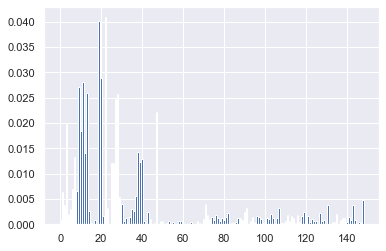

In [6]:
#Feature Selection - Top 20 Features 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif,SelectKBest
from matplotlib import pyplot

def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=mutual_info_classif, k=20)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [7]:
#Top 20 Features 
mask = fs.get_support()
new_features = X.columns[mask]
for col in new_features:
    print(col)

FLAG_OWN_REALTY
AMT_CREDIT_x
AMT_ANNUITY_x_1
AMT_GOODS_PRICE_x
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_CONT_MOBILE
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
FLAG_DOCUMENT_3


## EDA

## 1.Top features are statistically signifcant or not for Prediction

In [8]:
# Import  modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [9]:
m = ols('TARGET ~ CODE_GENDER',application_train).fit()
print(m.summary())


                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     945.3
Date:                Thu, 22 Oct 2020   Prob (F-statistic):          3.02e-207
Time:                        15:19:04   Log-Likelihood:                -35977.
No. Observations:              291057   AIC:                         7.196e+04
Df Residuals:                  291055   BIC:                         7.198e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0708      0.001    113.502      

In [10]:
m = sm.OLS(application_train.TARGET, application_train[['FLAG_OWN_REALTY', 'AMT_CREDIT_x', 'AMT_ANNUITY_x_1']]).fit()
print(m.summary())

                                 OLS Regression Results                                
Dep. Variable:                 TARGET   R-squared (uncentered):                   0.069
Model:                            OLS   Adj. R-squared (uncentered):              0.069
Method:                 Least Squares   F-statistic:                              7150.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):                        0.00
Time:                        15:19:05   Log-Likelihood:                         -38539.
No. Observations:              291057   AIC:                                  7.708e+04
Df Residuals:                  291054   BIC:                                  7.712e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [11]:
m = ols('TARGET ~ NAME_INCOME_TYPE',application_train).fit()
print(m.summary())


                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     611.0
Date:                Thu, 22 Oct 2020   Prob (F-statistic):          9.47e-135
Time:                        15:19:05   Log-Likelihood:                -36143.
No. Observations:              291057   AIC:                         7.229e+04
Df Residuals:                  291055   BIC:                         7.231e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0635      0.001  

##As it has high F statistics & P value almost 0 , so we can say above features are statitically signifcant for prediction

## 2 Hypothesis Test -OCCUPATION_TYPE

Null Hypo : OCCUPATION_TYPE doesn't have signifcat importance for repaying loan 


Alt Hypo : OCCUPATION_TYPE has significant impact for Repaying loan

In [12]:
from scipy.stats import t,ttest_ind_from_stats

grouped = application_train.groupby('TARGET')
# n0 no 
# n1 yes  
n0 = grouped.count().loc[0][0]
n1 = grouped.count().loc[1][0]
# Calculate mean
x0 = grouped.mean().loc[0,'OCCUPATION_TYPE']
x1 = grouped.mean().loc[1,'OCCUPATION_TYPE']
# Calculate STD
s0 = grouped.std().loc[0,'OCCUPATION_TYPE']
s1 = grouped.std().loc[1,'OCCUPATION_TYPE']
t_critical_stats, p_value_stats = ttest_ind_from_stats(x0, s0, n0, x1, s1, n1)
t_critical_stats,p_value_stats

(9.994138148092723, 1.631066018444426e-23)

As we got 9.9 as T value and p value almost 0 which is <=0.05 , so we can reject Null Hypothesis . That mean amount occupation type  has signifcat impact on repaying loan

## 3.Hypothesis Test for whether the NAME_INCOME_TYPE has any impact on Repayment of loan by shifting the averages

Null Hypo : There is no impact for repaying loan based on no of Income Type 
Alt Hypo : There is significant impact on repaying loan based on Income Type

In [13]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates. 
    Func refers to the type of statistic we want (np.mean / np.median etc.)"""
    
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(bs_sample)  # store the statistic from each bs_sample into the new array

    return bs_replicates

In [14]:
insured = np.array(application_train[application_train['TARGET']==1].NAME_INCOME_TYPE)
non_insured = np.array(application_train[application_train['TARGET']==0].NAME_INCOME_TYPE)

In [15]:
combined_mean = np.mean(np.concatenate((insured, non_insured)))
insured_shifted = insured - np.mean(insured) + combined_mean
non_insured_shifted = non_insured - np.mean(non_insured) + combined_mean
bs_replicates_insured = draw_bs_reps(insured_shifted, np.mean, size=1000)
bs_replicates_non_insured = draw_bs_reps(non_insured_shifted, np.mean, size=1000)
bs_differences = bs_replicates_insured - bs_replicates_non_insured
obs_diff = np.mean(insured) - np.mean(non_insured)
obs_diff
p = np.sum(bs_differences >= obs_diff)/ len(bs_differences)
p

0.0

As p =0 we can reject null hypo , there should be Highly significat impact on repaying loan based on Income Type

### Saving updated feature rich columned files  for  ML Indepth Analysis

In [16]:
#undersampling as our current ratio of 1 to 0 is only .9. 
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = application_train[application_train.TARGET==0]
df_minority = application_train[application_train.TARGET==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=20000,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.TARGET.value_counts()

1    23845
0    20000
Name: TARGET, dtype: int64

In [17]:
application_train_resampled=df_downsampled

In [18]:
application_train_resampled.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x_1,...,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,STATUS,Month_Balance_Count,Loan_Income_Ratio
165106,302278,0,0.0,0.0,0.0,1.0,0,180000.0,542133.0,19602.0,...,5270704.605,332628.66,8257.590,0.0,60.0,0.0,0.0,0.0,0.0,3.011850
3208,103923,0,0.0,0.0,1.0,1.0,1,135000.0,760225.5,30150.0,...,4648337.370,1701710.55,135000.000,0.0,39.0,0.0,0.0,0.0,0.0,5.631300
61138,174852,0,0.0,0.0,0.0,1.0,1,175500.0,1661418.0,45819.0,...,4162234.500,73084.50,0.000,0.0,26.0,0.0,0.0,0.0,0.0,9.466769
75518,192503,0,0.0,0.0,1.0,1.0,0,261000.0,781920.0,47965.5,...,2881258.650,461529.00,30375.495,0.0,31.0,0.0,0.0,0.0,0.0,2.995862
162034,298525,0,0.0,0.0,0.0,1.0,0,37008.0,285723.0,21492.0,...,247410.000,0.00,0.000,0.0,6.0,0.0,0.0,4.0,36.0,7.720574


In [19]:
new_application_train=application_train_resampled[new_features]
new_application_test=application_test[new_features]


In [20]:
new_application_train['TARGET']=application_train_resampled['TARGET']


<ipython-input-20-37c1d1a52f97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_application_train['TARGET']=application_train_resampled['TARGET']


In [21]:
new_application_test.shape

(47800, 20)

## Downsampled & Top 20 features dataset saved for Modeling 

In [22]:
new_application_train.to_csv('application_train_for_ML.csv',index=False)
new_application_test.to_csv('application_test_for_ML.csv',index=False)